In [175]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("whitegrid")

### Connect to database

In [176]:
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
driver1 = 'SQL+Server'
driver2 = 'ODBC+Driver+17+for+SQL+Server'
string1 = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver1}" 
string2 = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver2}" 
try: 
    conn = create_engine(string1).connect()
except:
    conn = create_engine(string2).connect() 

Exception during reset or similar
Traceback (most recent call last):
  File "c:\Users\kerry\AppData\Local\Programs\Python\Python310\lib\site-packages\sqlalchemy\pool\base.py", line 753, in _finalize_fairy
    fairy._reset(pool)
  File "c:\Users\kerry\AppData\Local\Programs\Python\Python310\lib\site-packages\sqlalchemy\pool\base.py", line 1004, in _reset
    pool._dialect.do_rollback(self)
  File "c:\Users\kerry\AppData\Local\Programs\Python\Python310\lib\site-packages\sqlalchemy\dialects\mssql\base.py", line 2792, in do_rollback
    super(MSDialect, self).do_rollback(dbapi_connection)
  File "c:\Users\kerry\AppData\Local\Programs\Python\Python310\lib\site-packages\sqlalchemy\engine\default.py", line 683, in do_rollback
    dbapi_connection.rollback()
pyodbc.Error: ('01000', '[01000] [Microsoft][ODBC SQL Server Driver][DBNETLIB]ConnectionWrite (send()). (10054) (SQLEndTran); [01000] [Microsoft][ODBC SQL Server Driver][DBNETLIB]General network error. Check your network documentation. (11

### Get adjusted closing prices and calculate returns and returns in excess of median

In [177]:
import pandas as pd 
price = pd.read_sql(
    """ 
    select date, ticker, closeadj from sep_weekly 
    where date>='2010-01-01'
    order by ticker, date  
    """,
    conn,
    parse_dates = ["date"],
    index_col = ["ticker", "date"]
)

ret = price.groupby("ticker", group_keys=False).pct_change()
target = ret.groupby("date", group_keys=False).apply(lambda x: x - x.median())

### Compute moving averages and logs of ratios

- Compute 4 week, 13 week, 26 week, and 52 week moving averages
- Define logs of ratios to use as predictors:
  - current price / 4 week moving avg
  - 4 week moving avg / 13 week moving avg
  - 13 week moving avg / 26 week moving avg
  - 26 week moving avg / 52 week moving avg

In [178]:
ma4 = price.groupby("ticker", group_keys=False).rolling(4).closeadj.mean()
ma13 = price.groupby("ticker", group_keys=False).rolling(13).closeadj.mean()
ma26 = price.groupby("ticker", group_keys=False).rolling(26).closeadj.mean()
ma52 = price.groupby("ticker", group_keys=False).rolling(52).closeadj.mean()
for d in [ma4, ma13, ma26, ma52]:
    d.index = d.index.droplevel(0)
p4 = np.log(price.closeadj/ma4)
p13 = np.log(ma4/ma13)
p26 = np.log(ma13/ma26)
p52 = np.log(ma26/ma52)

### Compute dummy variables for crossovers as additional predictors

Log of ratio switches sign when crossovers happen

- ratio switches from <1 to >1 when short term moves above long term
  - log of ratio switches from  <0 to >0 when this happens
- ratio switches from >1 to <1 when short term moves below long term
  - log of ratio switches from >0 to <0 when this happens

In [179]:
p4_lag = p4.groupby("ticker", group_keys=False).shift()
p13_lag = p13.groupby("ticker", group_keys=False).shift()
p26_lag = p26.groupby("ticker", group_keys=False).shift()
p52_lag = p52.groupby("ticker", group_keys=False).shift()

a4 = 1 * ((p4_lag<0) & (p4>0))
b4 = 1 * ((p4_lag>0) & (p4<0))
a13 = 1 * ((p13_lag<0) & (p13>0))
b13 = 1 * ((p13_lag>0) & (p13<0))
a26 = 1 * ((p26_lag<0) & (p26>0))
b26 = 1 * ((p26_lag>0) & (p26<0))
a52 = 1 * ((p52_lag<0) & (p52>0))
b52 = 1 * ((p52_lag>0) & (p52<0))

### Example

- Look at 4 week and 13 week moving averages for AAPL since 2022.
- One of the predictors is p13 = log(ma4/ma13)
- Another predictor is a13 = 1 when ma4 crosses ma13 from below (and a13 = 0 otherwise)
- Another predictor is b13 = 1 when ma4 crosses ma13 from above (and b13 = 0 otherwise)

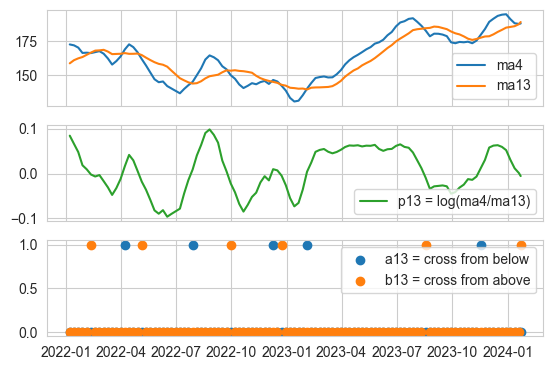

In [180]:
aapl_ma4 = ma4.xs("AAPL", level="ticker").loc["2022-01-01":]
aapl_ma13 = ma13.xs("AAPL", level="ticker").loc["2022-01-01":]
aapl_p13 = p13.xs("AAPL", level="ticker").loc["2022-01-01":]
aapl_a13 = a13.xs("AAPL", level="ticker").loc["2022-01-01":].reset_index()
aapl_b13 = b13.xs("AAPL", level="ticker").loc["2022-01-01":].reset_index()

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("whitegrid")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
aapl_ma4.plot(label="ma4", ax=ax1)
aapl_ma13.plot(label="ma13", ax=ax1)
ax1.legend()

aapl_p13.plot(label="p13 = log(ma4/ma13)", ax=ax2, c=sns.color_palette()[2])
ax2.legend()

plt.scatter(x=aapl_a13.date, y=aapl_a13.closeadj, label="a13 = cross from below")
plt.scatter(x=aapl_b13.date, y=aapl_b13.closeadj, label="b13 = cross from above")
ax3.legend()
plt.show()

### Combine return, target, and predictors (and filter to price >= 10)

In [187]:
df = pd.concat(
    (
        ret, target, price.closeadj, p4, p13, p26, p52,
        a4, b4, a13, b13, a26, b26, a52, b52
    ),
    axis=1
)
df.columns = [
    "ret", "target", "price", "p4", "p13", "p26", "p52",
    "a4", "b4", "a13", "b13", "a26", "b26", "a52", "b52"
]
df["ret"] = df.groupby("ticker", group_keys=False).ret.shift(-1)
df["target"] = df.groupby("ticker", group_keys=False).target.shift(-1)

df = df[df.price>=10]
df = df.dropna()
df = df.reset_index()

df["year"] = df.date.map(lambda x: x.year)
df = df.sort_values(by=["date", "ticker"])
df.to_csv("df.csv")

### Linear regression

In [188]:
string = """
    target ~ p4 + p13 + p26 + p52 + p4_delta + p13_delta + p26_delta + p52_delta 
    + a4 + b4 + a13 + b13 + a26 + b26 + a52 + b52
"""
result = smf.ols(string, df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     392.0
Date:                Thu, 25 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:44:17   Log-Likelihood:             2.3825e+06
No. Observations:             1984596   AIC:                        -4.765e+06
Df Residuals:                 1984579   BIC:                        -4.765e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0018   6.59e-05     27.401      0.000       0.002       0.002
p4             0.0041      0.002      2.296      0.022       0.001       0.008
p13            0.0019      0.001      2.137      0.033       0.000       0.004
p26           -0.0010      0.001     -1.128      0.259      -0.003       0.001
p52            0.0055      0.001     10.098      0.000       0.004       0.007
p4_delta      -0.0497      0.001    -38.501      0.000      -0.052      -0.047
p13_delta     -0.0745      0.003    -22.010      0.000      -0.081      -0.068
p26_delta     -0.1256      0.007    -18.533      0.000      -0.139      -0.112
p52_delta     -0.0814      0.008    -10.134      0.000      -0.097      -0.066
a4         -3.606e-05      0.000     -0.230      0.818      -0.000       0.000
b4            -0.0011      0.000     -7.276      0.000      -0.001      -0.001
a13            0.0011      0.000      4.284      0.000       0.001       0.002
b13           -0.0008      0.000     -3.283      0.001      -0.001      -0.000
a26            0.0017      0.000      4.517      0.000       0.001       0.002
b26           -0.0013      0.000     -3.507      0.000      -0.002      -0.001
a52            0.0010      0.001      2.004      0.045    2.31e-05       0.002
b52            0.0013      0.001      2.398      0.017       0.000       0.002
==============================================================================
Omnibus:                  4522719.773   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     672511341177.349
Skew:                          20.669   Prob(JB):                         0.00
Kurtosis:                    2854.502   Cond. No.                         187.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Backtest a random forest

In [189]:
features = [
    "p4", "p13", "p26", "p52", "p4_delta", "p13_delta", "p26_delta",
    "p52_delta", "a4", "b4", "a13", "b13", "a26", "b26", "a52", "b52"   
]
df2 = None 
forest = RandomForestRegressor(max_depth=4)

for year in range(2014, 2024):
    print(year)
    start = df[df.year == year].date.min()
    past = df[df.date < start]
    future = df[df.year == year].copy()
    forest.fit(X=past[features], y=past["target"])
    future["predict"] = forest.predict(X=future[features])
    df2 = pd.concat((df2, future))

df2.to_csv("df2.csv", index=False)
df2.head()

2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


### Compute portfolio returns

- Equally weighted portfolio of 100 best stocks
- Equally weighted portfolio of 100 worst stocks
- Equally weighted portfolio of all stocks

In [191]:
starting_from_best = df2.groupby(
    "date", 
    group_keys=False
).predict.rank(
    ascending=False, 
    method="first"
)
best = df2[starting_from_best <= 100]
best_rets = best.groupby("date", group_keys=True).ret.mean()
best_rets.index = pd.to_datetime(best_rets.index)

starting_from_worst = df2.groupby(
    "date", 
    group_keys=False
).predict.rank(
    ascending=True, 
    method="first"
)
worst = df2[starting_from_worst <= 100]
worst_rets = worst.groupby("date", group_keys=True).ret.mean()
worst_rets.index = pd.to_datetime(worst_rets.index)

all_rets = df2.groupby("date", group_keys=True).ret.mean()
all_rets.index = pd.to_datetime(all_rets.index)

### Plot performance

- Set logy = True to get a log plot.  
- In a log plot, the slope of a curve represents the percent change in the y variable per unit change in the x variable.

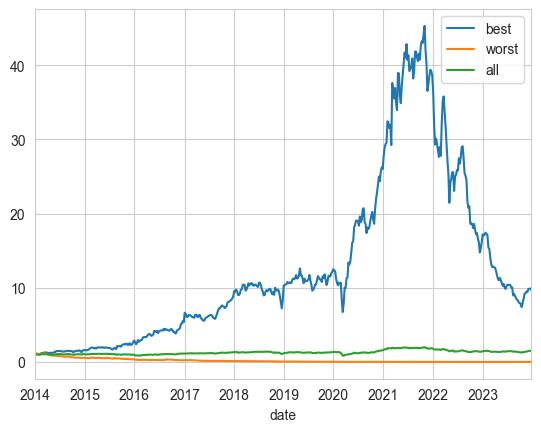

In [193]:
logy = False 

(1+best_rets).cumprod().plot(label="best", logy=logy)
(1+worst_rets).cumprod().plot(label="worst", logy=logy)
(1+all_rets).cumprod().plot(label="all", logy=logy)
plt.legend()
plt.show()

### Compare features of best and worst stocks

Look at portfolios on final date of backtest.

In [200]:
best_today = best[best.date == best.date.max()]
worst_today = worst[worst.date == worst.date.max()]
b = best_today[features].describe().iloc[1:].T
b.index.name = "stat"
b["group"] = "best"
b = b.reset_index().set_index(["stat", "group"])
w = worst_today[features].describe().iloc[1:].T
w.index.name = "stat"
w["group"] = "worst"
w = w.reset_index().set_index(["stat", "group"])
d = pd.concat((b, w))
d = d.unstack()
d.round(2)

mean           std           min           25%           50%  \
group       best  worst   best  worst   best  worst   best  worst   best   
stat                                                                       
a13        0.000  0.020  0.000  0.141  0.000  0.000  0.000  0.000  0.000   
a26        0.040  0.140  0.198  0.351  0.000  0.000  0.000  0.000  0.000   
a4         0.100  0.400  0.303  0.495  0.000  0.000  0.000  0.000  0.000   
a52        0.000  0.020  0.000  0.141  0.000  0.000  0.000  0.000  0.000   
b13        0.000  0.080  0.000  0.274  0.000  0.000  0.000  0.000  0.000   
b26        0.000  0.020  0.000  0.141  0.000  0.000  0.000  0.000  0.000   
b4         0.340  0.000  0.479  0.000  0.000  0.000  0.000  0.000  0.000   
b52        0.000  0.020  0.000  0.141  0.000  0.000  0.000  0.000  0.000   
p13        0.040  0.065  0.078  0.221 -0.127 -0.582  0.005 -0.031  0.036   
p13_delta  0.002  0.015  0.017  0.064 -0.031 -0.210 -0.005 -0.014 -0.001   
p26       -0.027 -0.045  0.069  0.206 -0.266 -0.905 -0.038 -0.068 -0.007   
p26_delta  0.002  0.012  0.009  0.027 -0.035 -0.044 -0.001 -0.005  0.001   
p4        -0.009  0.111  0.014  0.114 -0.065 -0.092 -0.016  0.034 -0.004   
p4_delta  -0.016  0.090  0.029  0.090 -0.114 -0.111 -0.036  0.050 -0.004   
p52        0.012 -0.178  0.097  0.621 -0.175 -3.427 -0.033 -0.176  0.014   
p52_delta -0.002  0.008  0.006  0.024 -0.022 -0.025 -0.003 -0.005 -0.000   

                    75%           max         
group      worst   best  worst   best  worst  
stat                                          
a13        0.000  0.000  0.000  0.000  1.000  
a26        0.000  0.000  0.000  1.000  1.000  
a4         0.000  0.000  1.000  1.000  1.000  
a52        0.000  0.000  0.000  0.000  1.000  
b13        0.000  0.000  0.000  0.000  1.000  
b26        0.000  0.000  0.000  0.000  1.000  
b4         0.000  1.000  0.000  1.000  0.000  
b52        0.000  0.000  0.000  0.000  1.000  
p13        0.019  0.072  0.159  0.425  0.669  
p13_delta  0.007  0.005  0.052  0.073  0.172  
p26       -0.012  0.009  0.052  0.107  0.392  
p26_delta  0.006  0.006  0.026  0.021  0.079  
p4         0.081  0.001  0.133  0.003  0.515  
p4_delta   0.075  0.003  0.114  0.024  0.412  
p52       -0.041  0.042  0.077  0.497  0.269  
p52_delta  0.004  0.001  0.011  0.010  0.102

### Plot distributions of individual features

<AxesSubplot: xlabel='group', ylabel='p4'>

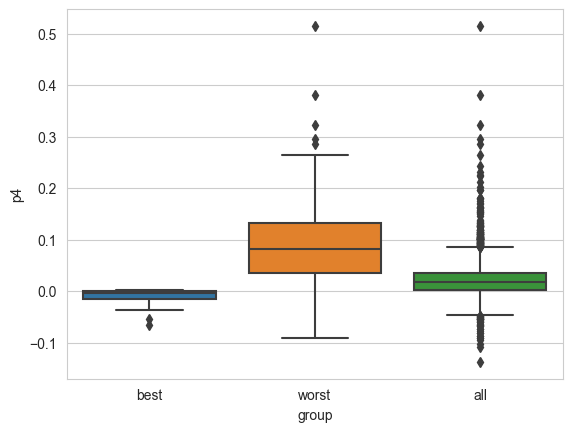

In [211]:
var = "p4"
b2 = pd.DataFrame(best_today[var])
b2["group"] = "best"
w2 = pd.DataFrame(worst_today[var])
w2["group"] = "worst"
a2 = df[df.date == best.date.max()]
a2 = pd.DataFrame(a2[var])
a2["group"] = "all"
d2 = pd.concat((b2, w2, a2))
sns.boxplot(data=d2, x="group", y=var)